# **1. Installing dependencies**

In [1]:
!pip install transformers

# **2. Import librairies and read data**

## **2.1. Import librairies**

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

## **2.2. Connect to the drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **2.3. Read data**

In [4]:
data = pd.read_csv("/content/gdrive/MyDrive/Projects_data/French_sntiment_analysis/French_Insurance.csv")

## **2.4. Show the top 5 lines**

In [5]:
data.head()

,Comment,Sentiment,Label
0,très satisfaite ! un conseiller à l'écoute et ...,1,Positive
1,je vous avais contacté pour la mise en place e...,1,Positive
2,"grâce à réassurez-moi, j'ai trouvé une mutuell...",1,Positive
3,encore merci à margaux pour son amabilité et s...,1,Positive
4,je suis une nouvelle client de réassurez-moi e...,1,Positive


In [6]:
df = data[["Comment",	"Sentiment"]]

# **3. Data analysis & visualisation**

## **3.1. Number of occurrences per sentiment**

In [7]:
df.Sentiment.value_counts()

1    1565
0    1565
2    1565
Name: Sentiment, dtype: int64

**Insight:**

- Our dataset is well-balanced (labels are equivalent)

In [8]:
sentiment = ['Negative', 'Positive', 'Neutral']
value = [1565, 1565, 1565]

## **3.2. Data visualisation**

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
data_S={'p_name':sentiment,
           'value':value}

In [10]:
df_S=pd.DataFrame.from_dict(data_S)

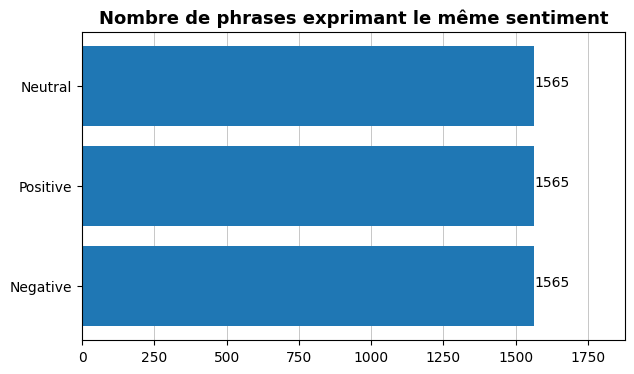

In [11]:
fig = plt.figure(figsize=(7,4))
ax1 = plt.subplot(1,1,1)
ax1.barh(df_S.p_name,df_S.value)
for Y_S, X_S in enumerate(df_S.value):
    ax1.annotate("{:}".format(X_S),xy=(X_S, Y_S))
ax1.set_xlim(0,df_S.value.max()*1.2)
ax1.xaxis.grid(linestyle='-',linewidth=0.5)
ax1.set_axisbelow(True)
ax1.set_title('Nombre de phrases exprimant le même sentiment', fontsize = 13, weight ="bold")
plt.show()

# **4. Data Preparation**

## **4.1. Load the bert tokenizer**

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

## **4.2. Sentences tokenization and words embedding**

In [13]:
token = tokenizer.encode_plus(
    df['Comment'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

### **Sentence representation (model entry)**

In [14]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,   189,  1197, 10695,  2068,  1548,  8057,  3150,   106,
         8362, 14255, 17191,  9860,   246,   181,   112,   255,  2528,
         6140,  3084,   188, 17162, 16606,  5484,   167,   167,   117,
         8910,  2430,  3818,  8362,   171,  1320,  1553, 11480,  5837,
         2149,   187,  2744, 11179, 11083, 27751,   132, 27466, 14596,
          194,   170,  8362,  5250,  1830,  1233, 25266,   117,   172,
         9945, 12890,   187, 10051,  4063,  1358,  6099, 14529,  3084,
          181,   112,  1113,   191,  2285,  5069,  2227, 12686,  1884,
         4084,  2227,  8910,  3014,  4555,  1162,   119,   179,   112,
          170,  1182, 23609,   189, 20645,  1964,  2744,  2495,  1532,
         8722,  1260,   182,  3818, 24741,  1513,   186,  6592,  1143,
        18420, 21263,  5837,  1940, 24642,  3084,   246,  8362,   185,
        14799,  1107, 14608,  7370,  2861, 14247,  3080,  8362,  6047,
         1162, 22572,  8136, 

## **4.3. Training data generator**

### **Initialze the containers of our entry model by zeros**

In [15]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [16]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Comment'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

### **Generate traininig data**

In [17]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

**- X_input_ids  :** An array containing the encoded words

**- X_attn_masks :** An array of the same length as the X_input_ids array, filled with "1" and "0". "1" when an element of the X_input_ids array with the same index is different from "0", otherwise "0".

In [18]:
labels = np.zeros((len(df), 3))
labels.shape

(4695, 3)

### **Encode the labels (Target)**

In [19]:
labels[np.arange(len(df)), df['Sentiment'].values] = 1 # one-hot encoded target tensor

In [20]:
labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

### **Creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...**

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

In [22]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

### **Converting to required format for tensorflow dataset**

In [23]:
dataset = dataset.map(SentimentDatasetMapFunction)

In [24]:
dataset.take(1)


<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.float64, name=None))>

### **Divide the data into batches**

In [25]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=False)

### **Split data into training and validation sets**

In [26]:
p = 0.8
train_size = int((len(df)//16)*p)

In [27]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# **5. Model**

## **5.1. Load the Bert model**

In [28]:
from transformers import TFBertModel

In [29]:
bert_model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## **5.2. Model building**

In [30]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = bert_model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(64, activation='relu', name='intermediate_layer')(bert_embds)
# intermediate_layer_2 = tf.keras.layers.Dense(64, activation='relu', name='intermediate_layer_2')(intermediate_layer_1)
output_layer = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [31]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [32]:
class custom_Callback(tf.keras.callbacks.Callback):
    def __init__(self, patience, accuracy_threshold):
        super(custom_Callback, self).__init__()
        self.patience = patience
        self.accuracy_threshold = accuracy_threshold
        self.stopped_epoch = 0
        self.wait = 0

    def on_epoch_end(self, epoch, logs={}):
        current_accuracy = logs.get("accuracy")

        if current_accuracy is not None and current_accuracy < 0.95:
          if current_accuracy > self.accuracy_threshold:
              self.wait += 1
              if self.wait >= self.patience:
                  print(f"\nTraining stopped as accuracy remained above {self.accuracy_threshold} for {self.patience} epochs.")
                  self.model.stop_training = True
              else:
                  self.stopped_epoch = epoch
        else:
          self.model.stop_training = True

callback = custom_Callback(accuracy_threshold=0.85, patience=4)

In [33]:
model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

## **5.3. Start training the model**

In [34]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks = [callback]
)

Epoch 1/15
234/234 [==============================] - 248s 975ms/step - loss: 0.9848 - accuracy: 0.4840 - val_loss: 0.9096 - val_accuracy: 0.5342
Epoch 2/15
234/234 [==============================] - 225s 963ms/step - loss: 0.8800 - accuracy: 0.5694 - val_loss: 0.7685 - val_accuracy: 0.6267
Epoch 3/15
234/234 [==============================] - 225s 960ms/step - loss: 0.6833 - accuracy: 0.7110 - val_loss: 0.5385 - val_accuracy: 0.8118
Epoch 4/15
234/234 [==============================] - 224s 957ms/step - loss: 0.5235 - accuracy: 0.7917 - val_loss: 0.4034 - val_accuracy: 0.8465
Epoch 5/15
234/234 [==============================] - 224s 959ms/step - loss: 0.4237 - accuracy: 0.8403 - val_loss: 0.2507 - val_accuracy: 0.9127
Epoch 6/15
234/234 [==============================] - 223s 953ms/step - loss: 0.3224 - accuracy: 0.8835 - val_loss: 0.1930 - val_accuracy: 0.9369
Epoch 7/15
234/234 [==============================] - 223s 954ms/step - loss: 0.2721 - accuracy: 0.9044 - val_loss: 0.1285 -

## **5.4. Analyse the model perfomance during training/testing per iteration**

### **5.4.1. Model accuracy progress during training/testing per iteration**

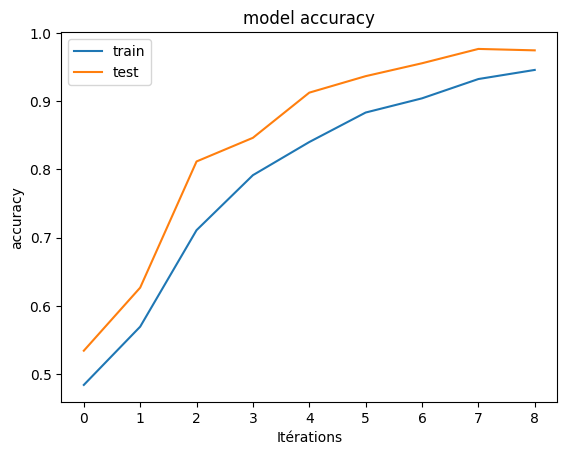

In [35]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Itérations')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **5.4.2. Model loss progress during training/testing per iteration**

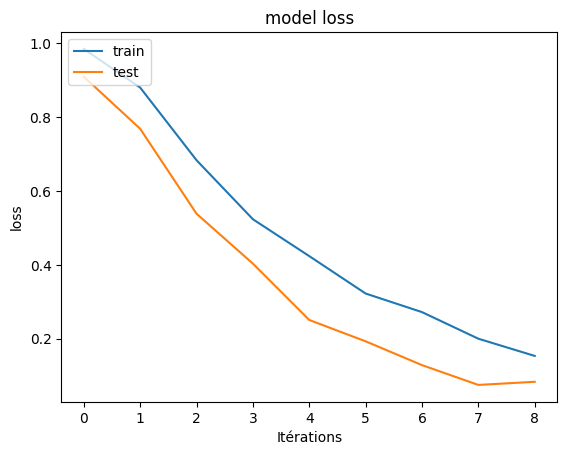

In [36]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Itérations')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **5.5. Save the model**

In [37]:
model.save("sentiment_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Prediction**

In [38]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [39]:
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=["Negative", "Positive", "Neutral"]):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

In [40]:
sentiment_model = tf.keras.models.load_model('sentiment_model.h5')

In [43]:
input_text = input('Saisissez une phrase: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(sentiment_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

Saisissez une phrase: Haha, ne t'inquiète pas! Vous en ferrez tout!
1/1 [==============================] - 0s 99ms/step
Predicted Sentiment: Neutral
